In [2]:
import numpy as np
import matplotlib.pyplot as plt

from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets, UCR_UEA_datasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
from tslearn.metrics import dtw, soft_dtw

In [3]:
def calc_bic(X_train, km, k_cluster, soft=0):
    bic = 0
    for n in range(len(X_train)):
        p_sum = 0
        for i in range(k_cluster):
            if soft == 0:
                dist = dtw(X_train[n], km.cluster_centers_[i])
            elif soft == 1:
                dist = soft_dtw(X_train[n], km.cluster_centers_[i], gamma=0.01)
            p_ = np.exp(-(dist**2)/2) / (2*np.pi)**(1/2)
            p_sum += p_
        
        bic -= np.log(p_sum / k_cluster)
    bic += k_cluster * X_train.shape[1] * np.log(X_train.shape[0]) / 2

    return bic

def calc_aic(X_train, km, k_cluster, soft=0):
    aic = 0
    for n in range(len(X_train)):
        p_sum = 0
        for i in range(k_cluster):
            if soft == 0:
                dist = dtw(X_train[n], km.cluster_centers_[i])
            elif soft == 1:
                dist = soft_dtw(X_train[n], km.cluster_centers_[i], gamma=0.01)
            p_ = np.exp(-(dist**2)/2) / (2*np.pi)**(1/2)
            p_sum += p_
        
        aic -= np.log(p_sum / k_cluster)
    aic += k_cluster * X_train.shape[1]

    return aic

In [18]:
# 可視化メソッド
def plot_result(X_train, y_train, aic_li, km_li, name):
    plt.figure(figsize=(12,5))

    # true
    plt.subplot(1, 2, 1)
    label = np.unique(y_train)
    # カラーマップを定義
    cmap = plt.get_cmap('tab10')  # タブルランカラーマップを使用
    colors = [cmap(i) for i in range(len(label))]

    for class_label in label:
        class_data = X_train[y_train == class_label][:,:,0].T
        plt.plot(class_data, label=f'_Class {class_label}', color=colors[class_label - 1], alpha=0.4)
        plt.plot([], label=f'Class {class_label}', color=colors[class_label - 1], alpha=0.3)

    plt.legend()
    # plt.text(0.05,0.95,'pred', transform=plt.gca().transAxes)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(f'{name} True')

    # pred
    plt.subplot(1,2,2)
    best_ind = np.argmin(aic_li)
    best_k = best_ind + 1
    best_km = km_li[best_ind]
    y_pred = best_km.predict(X_train) + 1

    label = np.unique(y_pred)
    # カラーマップを定義
    cmap = plt.get_cmap('tab10')  # タブルランカラーマップを使用
    colors = [cmap(i) for i in range(len(label))]

    for class_label in label:
        class_data = X_train[y_pred == class_label][:,:,0].T
        plt.plot(class_data, label=f'_Class {class_label}', color=colors[class_label - 1], alpha=0.1)
        plt.plot(best_km.cluster_centers_[class_label - 1], label=f'Class {class_label}',
                color=colors[class_label - 1], linewidth=3)

    plt.legend()
    # plt.text(0.05,0.95,'pred', transform=plt.gca().transAxes)
    plt.xlabel('Time')
    plt.title(f'{name} Pred')
    plt.tight_layout()
    plt.show()

DBA k-means 1
	aic:  1439.4837968897282
DBA k-means 2
	aic:  842.2709885518707
DBA k-means 3
	aic:  1063.6860956028827
DBA k-means 4
	aic:  1346.5196815689737
DBA k-means 5
	aic:  1633.5417888848976


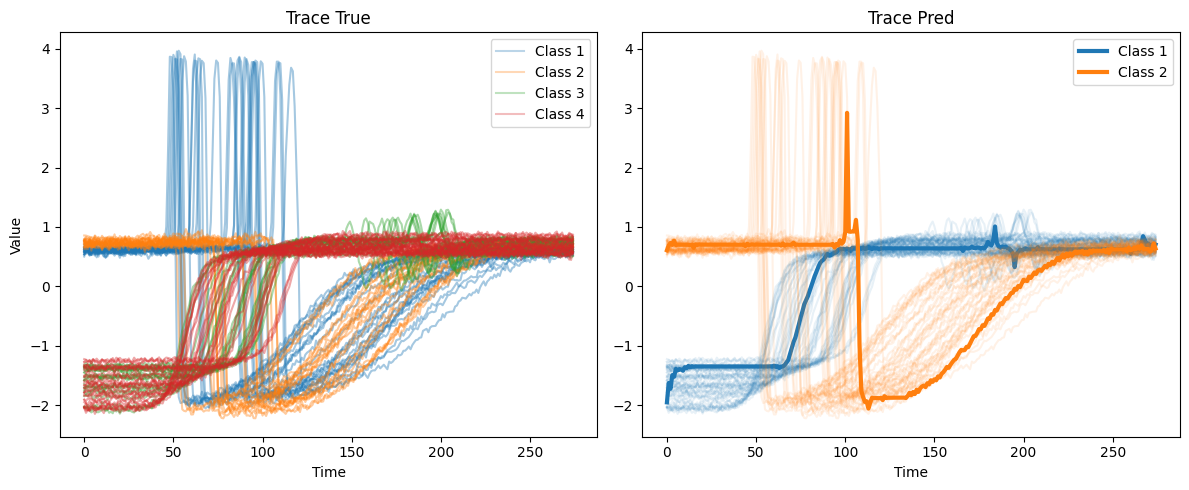

In [19]:
seed = 0
np.random.seed(seed)
name='Trace'
X_train, y_train, X_test, y_test = CachedDatasets().load_dataset(name)
# Keep only 50 time series

# Make time series shorter
# X_train = TimeSeriesResampler(sz=40).fit_transform(X_train)
sz = X_train.shape[1]

# DBA-k-means
aic_li = []
km_li = []
for i in range(5):
    k_cluster = i+1

    print(f'DBA k-means {k_cluster}')
    dba_km = TimeSeriesKMeans(n_clusters=k_cluster,
                                n_init=2,
                                metric="dtw",
                                verbose=False,
                                max_iter_barycenter=10,
                                random_state=seed)
    y_pred = dba_km.fit_predict(X_train)
    km_li.append(dba_km)
    aic_li.append(calc_aic(X_train, dba_km, k_cluster, 0))

    print('\taic: ', aic_li[i])

plot_result(X_train, y_train, aic_li, km_li, name)

系列長を1/2にした

DBA k-means 1
	aic:  632.1746820910914
DBA k-means 2
	aic:  539.3936989019344
DBA k-means 3
	aic:  655.7202496721999
DBA k-means 4
	aic:  799.4499562265412
DBA k-means 5
	aic:  940.3636767657688


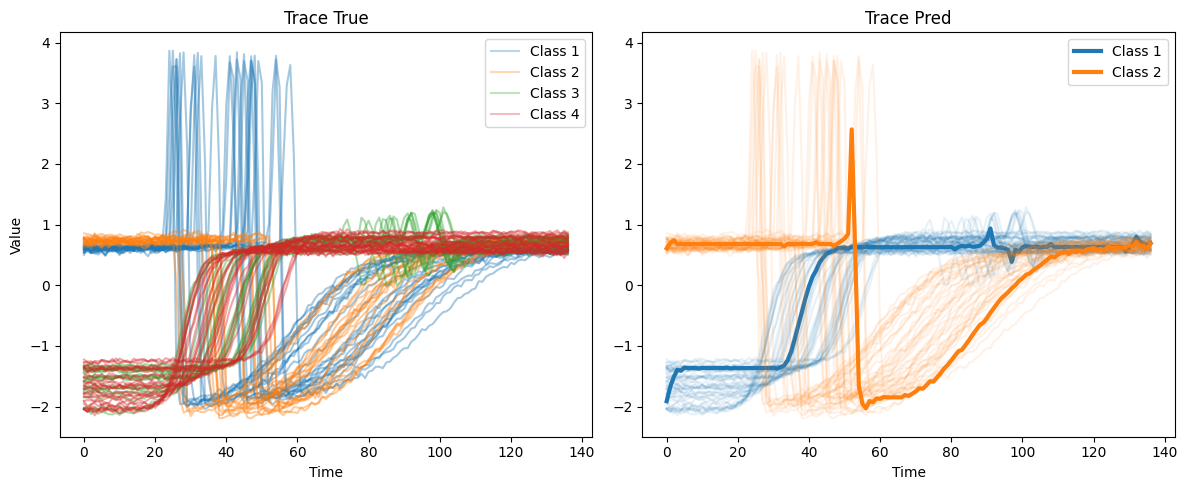

In [20]:
seed = 0
np.random.seed(seed)
name='Trace'
X_train, y_train, X_test, y_test = CachedDatasets().load_dataset(name)
# Keep only 50 time series

# Make time series shorter
X_train = TimeSeriesResampler(sz=int(X_train.shape[1]/2)).fit_transform(X_train)
sz = X_train.shape[1]

# DBA-k-means
aic_li = []
km_li = []
for i in range(5):
    k_cluster = i+1

    print(f'DBA k-means {k_cluster}')
    dba_km = TimeSeriesKMeans(n_clusters=k_cluster,
                                n_init=2,
                                metric="dtw",
                                verbose=False,
                                max_iter_barycenter=10,
                                random_state=seed)
    y_pred = dba_km.fit_predict(X_train)
    km_li.append(dba_km)
    aic_li.append(calc_aic(X_train, dba_km, k_cluster, 0))

    print('\taic: ', aic_li[i])

plot_result(X_train, y_train, aic_li, km_li, name)

DBA k-means 1
	aic:  188.4106422126494
DBA k-means 2
	aic:  317.65583014570177
DBA k-means 3
	aic:  447.7377766212792
DBA k-means 4
	aic:  582.2728921267375
DBA k-means 5
	aic:  704.350902698086


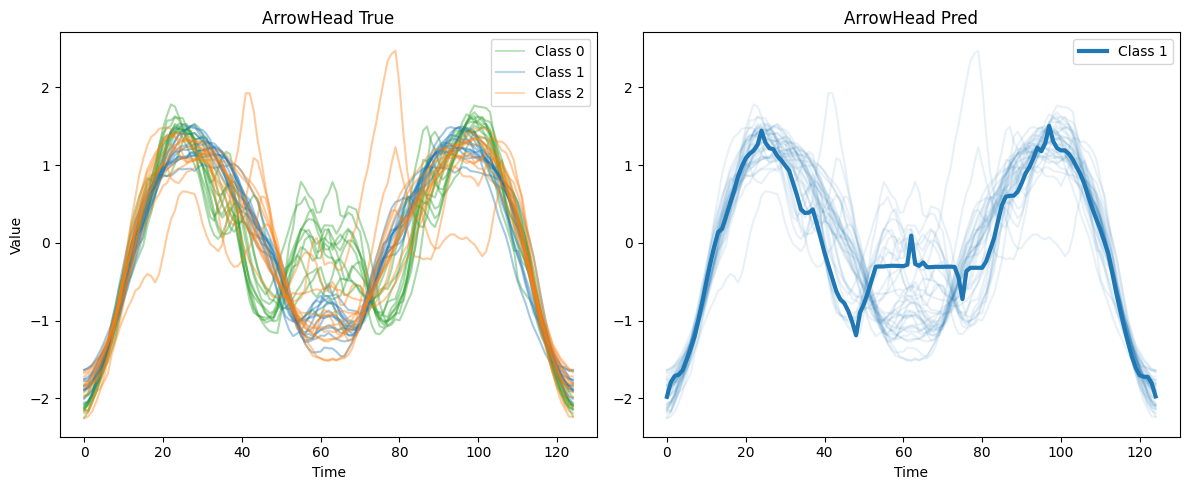

DBA k-means 1
	aic:  443.0366802659476
DBA k-means 2
	aic:  600.9715260387759
DBA k-means 3
	aic:  818.8540404797997
DBA k-means 4
	aic:  1037.61024873344
DBA k-means 5
	aic:  1272.612626722361


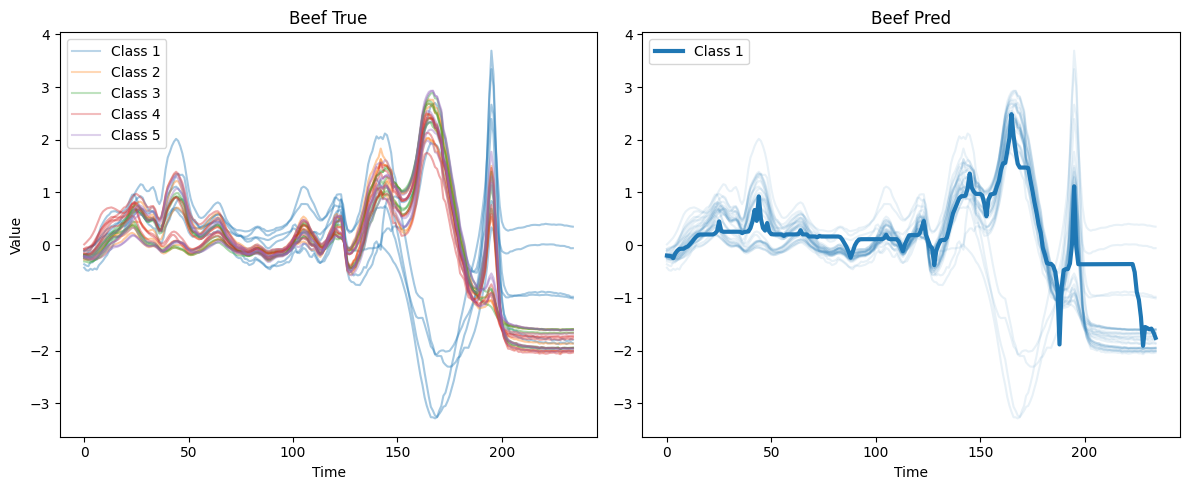

DBA k-means 1
	aic:  369.2047241252196
DBA k-means 2
	aic:  669.2423008376014
DBA k-means 3
	aic:  962.1756241204392
DBA k-means 4
	aic:  1262.5797222013512
DBA k-means 5
	aic:  1545.6982317333157


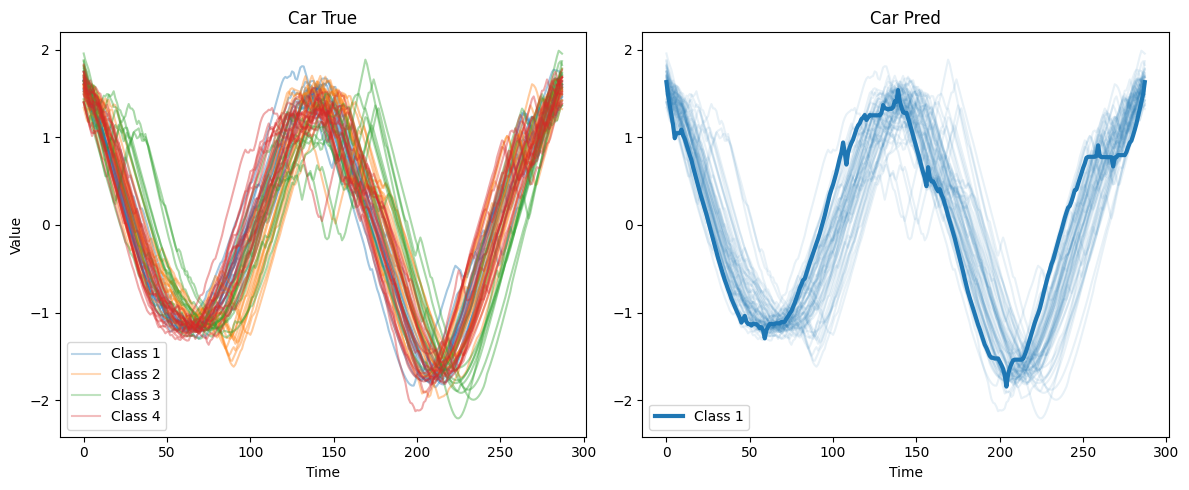

In [21]:
seed = 0
np.random.seed(seed)
name_li = [
            'ArrowHead','Beef','Car',
]

for name in name_li:
    X_train, y_train, X_test, y_test = UCR_UEA_datasets().load_dataset(name)
    # Keep only 50 time series

    # Make time series shorter
    X_train = TimeSeriesResampler(sz=int(X_train.shape[1]/2)).fit_transform(X_train)
    sz = X_train.shape[1]

    # DBA-k-means
    aic_li = []
    km_li = []
    for i in range(5):
        k_cluster = i+1

        print(f'DBA k-means {k_cluster}')
        dba_km = TimeSeriesKMeans(n_clusters=k_cluster,
                                    n_init=2,
                                    metric="dtw",
                                    verbose=False,
                                    max_iter_barycenter=10,
                                    random_state=seed)
        y_pred = dba_km.fit_predict(X_train)
        km_li.append(dba_km)
        aic_li.append(calc_aic(X_train, dba_km, k_cluster, 0))

        print('\taic: ', aic_li[i])

    plot_result(X_train, y_train, aic_li, km_li, name)

BICに変更

DBA k-means 1
	bic:  287.3805758661563
DBA k-means 2
	bic:  515.5956974527155
DBA k-means 3
	bic:  744.6475775817997
DBA k-means 4
	bic:  978.152626740765
DBA k-means 5
	bic:  1199.2005709656203


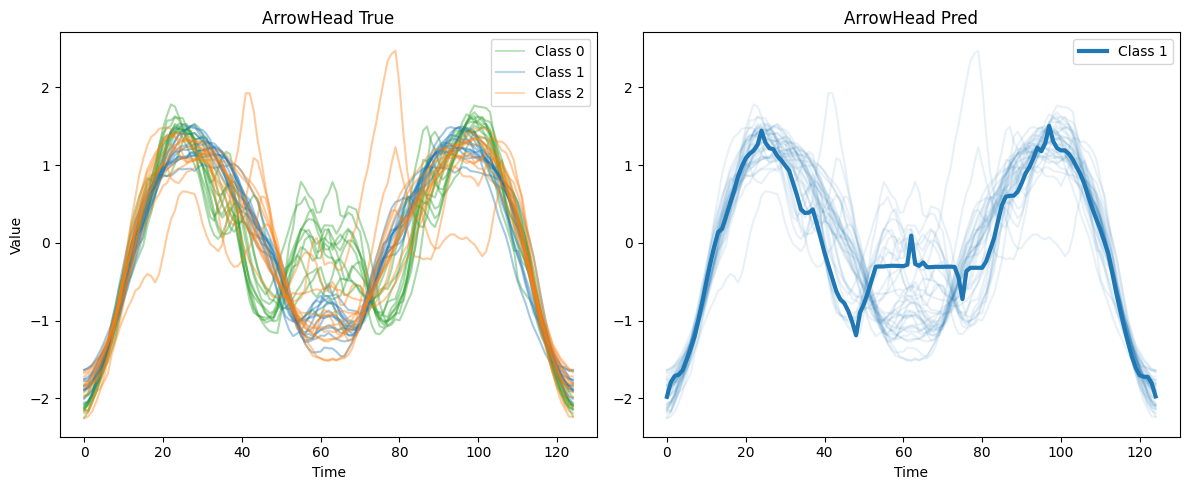

DBA k-means 1
	bic:  607.6773726112508
DBA k-means 2
	bic:  930.2529107293824
DBA k-means 3
	bic:  1312.7761175157095
DBA k-means 4
	bic:  1696.173018114653
DBA k-means 5
	bic:  2095.8160884488775


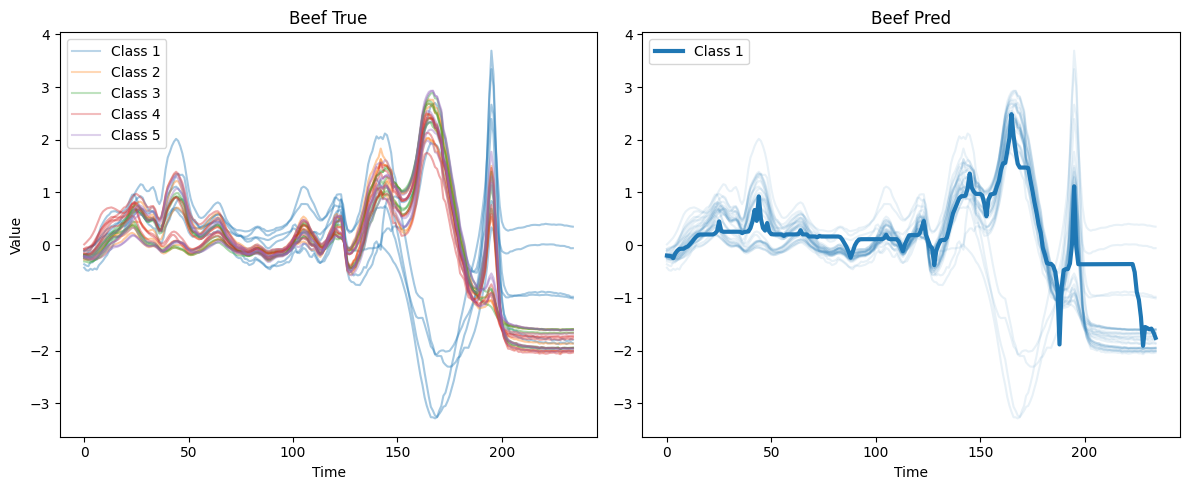

DBA k-means 1
	bic:  670.790341085202
DBA k-means 2
	bic:  1272.4135347575664
DBA k-means 3
	bic:  1866.9324750003868
DBA k-means 4
	bic:  2468.922190041281
DBA k-means 5
	bic:  3053.6263165332275


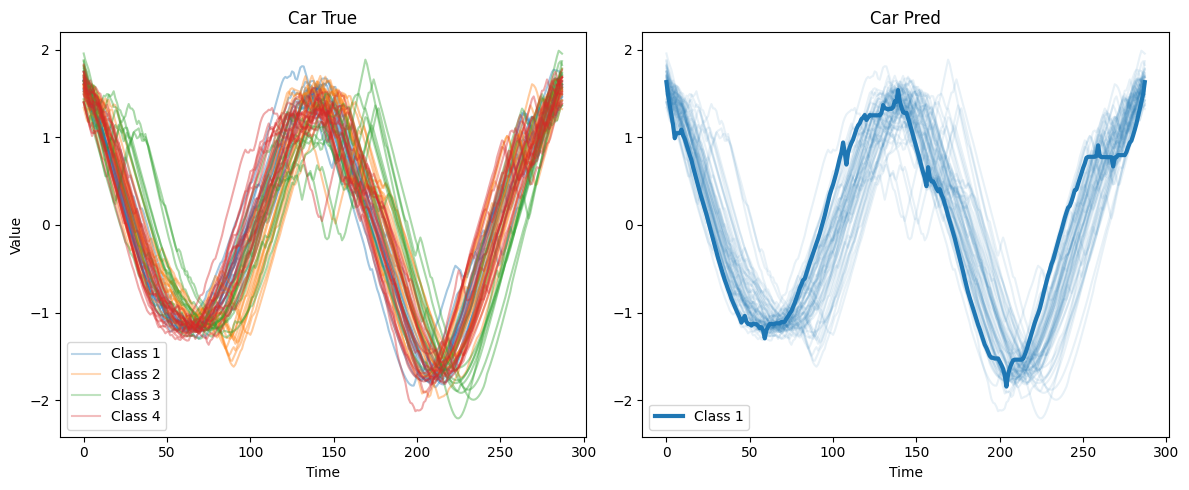

In [23]:
seed = 0
np.random.seed(seed)
name_li = [
            'ArrowHead','Beef','Car',
]

for name in name_li:
    X_train, y_train, X_test, y_test = UCR_UEA_datasets().load_dataset(name)
    # Keep only 50 time series

    # Make time series shorter
    X_train = TimeSeriesResampler(sz=int(X_train.shape[1]/2)).fit_transform(X_train)
    sz = X_train.shape[1]

    # DBA-k-means
    bic_li = []
    km_li = []
    for i in range(5):
        k_cluster = i+1

        print(f'DBA k-means {k_cluster}')
        dba_km = TimeSeriesKMeans(n_clusters=k_cluster,
                                    n_init=2,
                                    metric="dtw",
                                    verbose=False,
                                    max_iter_barycenter=10,
                                    random_state=seed)
        y_pred = dba_km.fit_predict(X_train)
        km_li.append(dba_km)
        bic_li.append(calc_bic(X_train, dba_km, k_cluster, 0))

        print('\tbic: ', bic_li[i])

    plot_result(X_train, y_train, bic_li, km_li, name)

系列の長さに対して、データごとの変動が小さく、情報量基準だと複数クラスターとして認識してくれない

実用を想定すると、、、正常データが多い場合に、異常データを軽視してしまい分類がうまくいかない可能性が予想される

soft-DTWを試してみる

Soft-DTW k-means 1
	aic:  695.7241326965367
Soft-DTW k-means 2
	aic:  537.0450251062933
Soft-DTW k-means 3
	aic:  657.118852043508
Soft-DTW k-means 4
	aic:  802.3490378499934
Soft-DTW k-means 5
	aic:  948.5558506288532


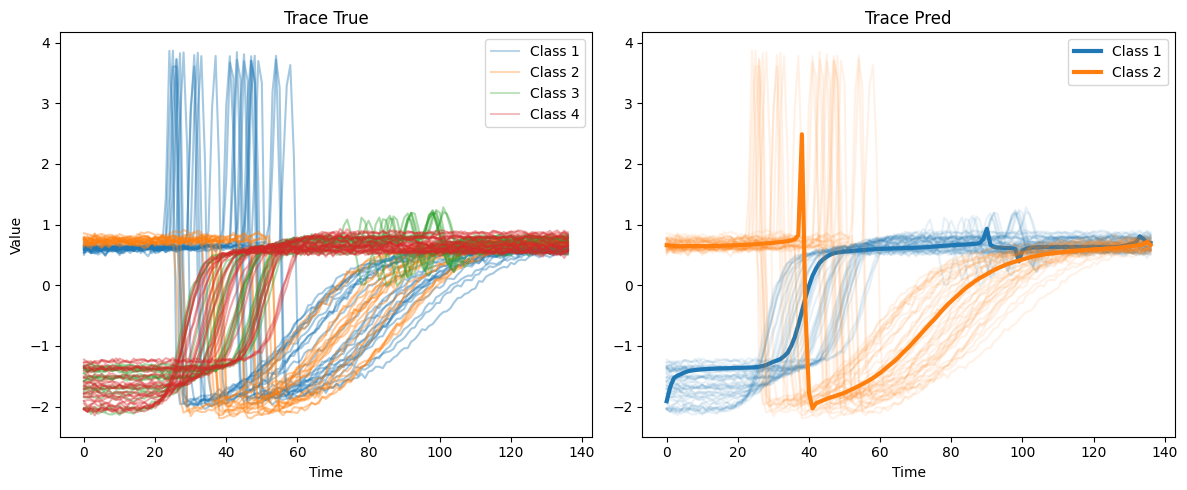

In [25]:
seed = 0
np.random.seed(seed)
name='Trace'
X_train, y_train, X_test, y_test = CachedDatasets().load_dataset(name)
# Keep only 50 time series

# Make time series shorter
X_train = TimeSeriesResampler(sz=int(X_train.shape[1]/2)).fit_transform(X_train)
sz = X_train.shape[1]

# DBA-k-means
aic_li = []
km_li = []
for i in range(5):
    k_cluster = i+1

    print(f'Soft-DTW k-means {k_cluster}')
    sdtw_km = TimeSeriesKMeans(n_clusters=k_cluster,
                                metric="softdtw",
                                metric_params={"gamma": .01},
                                verbose=False,
                                random_state=seed)
    y_pred = sdtw_km.fit_predict(X_train)
    km_li.append(sdtw_km)
    aic_li.append(calc_aic(X_train, sdtw_km, k_cluster, 0))

    print('\taic: ', aic_li[i])

plot_result(X_train, y_train, aic_li, km_li, name)

Soft-DTW k-means 1
	aic:  187.89001500083737
Soft-DTW k-means 2
	aic:  323.369083516822
Soft-DTW k-means 3
	aic:  450.9208071080661
Soft-DTW k-means 4
	aic:  582.5559723446083
Soft-DTW k-means 5
	aic:  709.5348740128105


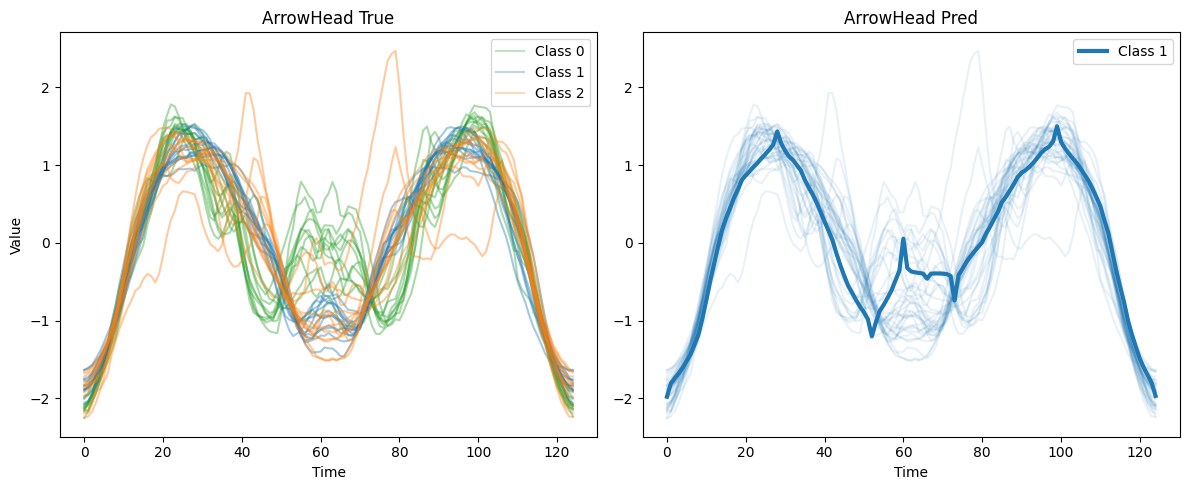

Soft-DTW k-means 1
	aic:  424.1921337863978
Soft-DTW k-means 2
	aic:  599.7047332150754
Soft-DTW k-means 3
	aic:  824.6834820479606
Soft-DTW k-means 4
	aic:  1063.5674462660663
Soft-DTW k-means 5
	aic:  1272.2889764997678


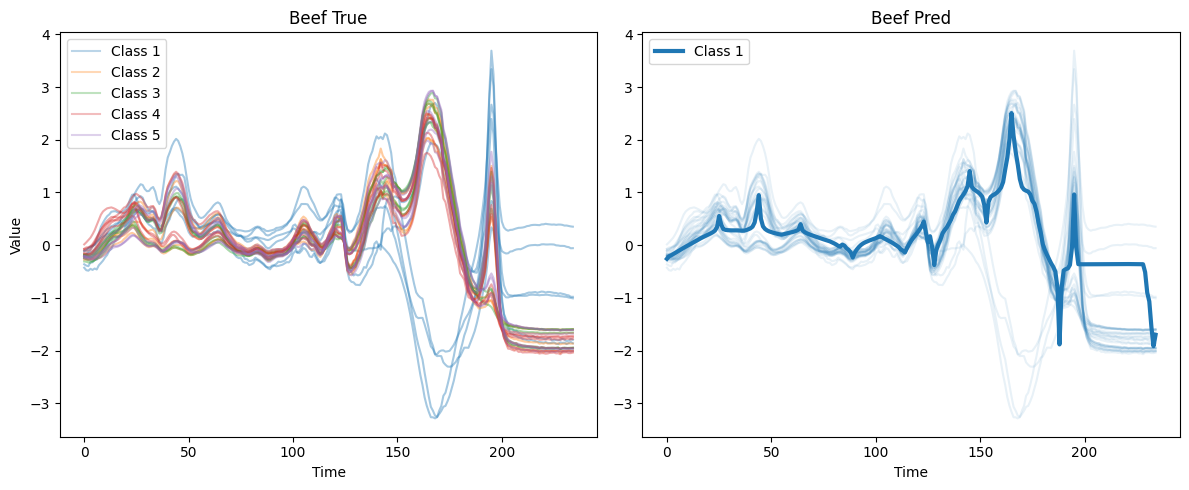

Soft-DTW k-means 1
	aic:  369.2720613458686
Soft-DTW k-means 2
	aic:  662.8966257220918
Soft-DTW k-means 3
	aic:  953.9721959201011
Soft-DTW k-means 4
	aic:  1241.906808192805
Soft-DTW k-means 5
	aic:  1536.2828982980511


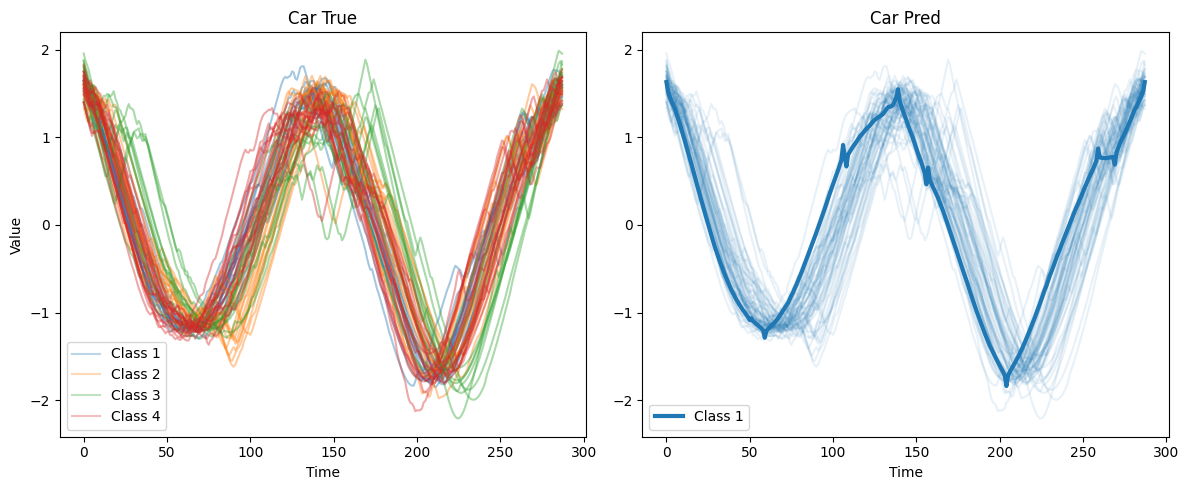

In [26]:
seed = 0
np.random.seed(seed)
name_li = [
            'ArrowHead','Beef','Car',
]

for name in name_li:
    X_train, y_train, X_test, y_test = UCR_UEA_datasets().load_dataset(name)
    # Keep only 50 time series

    # Make time series shorter
    X_train = TimeSeriesResampler(sz=int(X_train.shape[1]/2)).fit_transform(X_train)
    sz = X_train.shape[1]

    # DBA-k-means
    aic_li = []
    km_li = []
    for i in range(5):
        k_cluster = i+1

        print(f'Soft-DTW k-means {k_cluster}')
        sdtw_km = TimeSeriesKMeans(n_clusters=k_cluster,
                                    metric="softdtw",
                                    metric_params={"gamma": .01},
                                    verbose=False,
                                    random_state=seed)
        y_pred = sdtw_km.fit_predict(X_train)
        km_li.append(sdtw_km)
        aic_li.append(calc_aic(X_train, sdtw_km, k_cluster, 0))

        print('\taic: ', aic_li[i])

    plot_result(X_train, y_train, aic_li, km_li, name)

soft-DTWにしてもクラスター数の検出精度は低いまま